In [1]:
import os
import glob
import json
from datetime import datetime
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
from scipy.stats import binom
import pandas as pd

# folder containing your JSONL files
folder_path = "study-data"

In [2]:
# Aggregate across all files
all_times_by_condition = defaultdict(list)
all_time1_2_by_condition = defaultdict(list)
all_time2_3_by_condition = defaultdict(list)
all_change_counts_by_condition = defaultdict(Counter)

# Process each JSONL file
for jsonl_path in glob.glob(os.path.join(folder_path, "*.jsonl")):
    print(f"Processing file: {os.path.basename(jsonl_path)}")

    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue

            # Parse JSON object
            try:
                record = json.loads(line)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON on line {line_num} in file {jsonl_path}")
                continue

            user_answer = record.get("user_answer", {})

            for key in user_answer:
                if "first_choice" in key:
                    # E.g. key = "7first_choiceC3"
                    qnum_part, cond_part = key.split("first_choice")
                    question_num = qnum_part
                    condition = cond_part

                    first_key = f"{question_num}first_choice{condition}"
                    second_key = f"{question_num}second_choice{condition}"
                    third_key = f"{question_num}third_choice{condition}"

                    try:
                        # Get timestamps
                        first_time_str = user_answer[first_key][0]
                        second_time_str = user_answer[second_key][0]
                        third_time_str = user_answer[third_key][0]

                        first_time = datetime.fromisoformat(first_time_str)
                        second_time = datetime.fromisoformat(second_time_str)
                        third_time = datetime.fromisoformat(third_time_str)

                        time1_2 = (second_time - first_time).total_seconds()
                        time2_3 = (third_time - second_time).total_seconds()
                        total_time = (third_time - first_time).total_seconds()

                        all_time1_2_by_condition[condition].append(time1_2)
                        all_time2_3_by_condition[condition].append(time2_3)
                        all_times_by_condition[condition].append(total_time)

                        # Get choices
                        first_choice = user_answer[first_key][1]
                        second_choice = user_answer[second_key][1]
                        third_choice = user_answer[third_key][1]

                        # Analyze changes
                        changes = 0
                        if first_choice != second_choice:
                            changes += 1
                        if second_choice != third_choice:
                            changes += 1

                        if changes == 0:
                            change_type = "no_change"
                        elif changes == 1:
                            change_type = "one_change"
                        else:
                            change_type = "two_changes"

                        all_change_counts_by_condition[condition][change_type] += 1

                    except (KeyError, ValueError, IndexError):
                        continue

Processing file: 66bfdc082ffe8d45b60263a6.jsonl
Processing file: 663a94c4f1f80e7c9c8a2d19.jsonl
Processing file: 678e6eb7170e3a5da7c4ab91.jsonl
Processing file: 673276b17430c6ece3a6d874.jsonl
Processing file: 67d29a840debd6b228515177.jsonl
Processing file: 5d7ff85ffec5620017b07c40.jsonl
Processing file: 670453b0d93209a1e156916d.jsonl
Processing file: 5be87e33a14b540001aa2ea5.jsonl
Processing file: 66c5118758e462c3fe742d2a.jsonl
Processing file: 66e62716a40afa9a9b4d23c6.jsonl
Processing file: 60ec03471451032a030cfec1.jsonl
Processing file: 559e6830fdf99b4f0b98514a.jsonl
Processing file: 667901b2c2574ecf30bf6d3b.jsonl
Processing file: 65f4ab7884f8411c9e11a34e.jsonl
Processing file: 6422f34be2b8257efb345837.jsonl
Processing file: 63474e67a5fd298c6103c409.jsonl
Processing file: 5cfc38f7ee119e001803dd01.jsonl
Processing file: 5f1dfd940aeb060d8eb3cf55.jsonl
Processing file: 67e88a0303c1b7693d1a0c6f.jsonl
Processing file: 667c7880d80864f94fd000bc.jsonl
Processing file: 668ebf594982c57c983cd91

In [3]:
pid_counts = Counter()

for jsonl_path in glob.glob(os.path.join(folder_path, "*.jsonl")):
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                record = json.loads(line)
                pid = record.get("PID")
                if pid is not None:
                    pid_counts[pid] += 1
            except json.JSONDecodeError:
                continue

print("PID counts:")
for pid, count in pid_counts.items():
    print(f"PID {pid}: {count}")

PID counts:
PID 3: 4
PID 5: 4
PID 1: 4
PID 2: 4
PID 6: 4
PID 4: 4



=== Overall summary across ALL files ===

Condition C1:
  Total questions: 95
  Time 1→2 mean: 13.36 ± 2.60 sec
  Time 2→3 mean: 20.43 ± 3.00 sec
  Total time mean: 33.78 ± 4.04 sec
    no_change: 63 times (66.3%)
    one_change: 20 times (21.1%)
    two_changes: 12 times (12.6%)

Condition C2:
  Total questions: 96
  Time 1→2 mean: 15.61 ± 3.67 sec
  Time 2→3 mean: 16.79 ± 3.30 sec
  Total time mean: 32.40 ± 5.53 sec
    no_change: 54 times (56.2%)
    one_change: 29 times (30.2%)
    two_changes: 13 times (13.5%)

Condition C3:
  Total questions: 95
  Time 1→2 mean: 11.10 ± 4.43 sec
  Time 2→3 mean: 52.94 ± 9.61 sec
  Total time mean: 64.04 ± 11.26 sec
    no_change: 63 times (66.3%)
    one_change: 23 times (24.2%)
    two_changes: 9 times (9.5%)


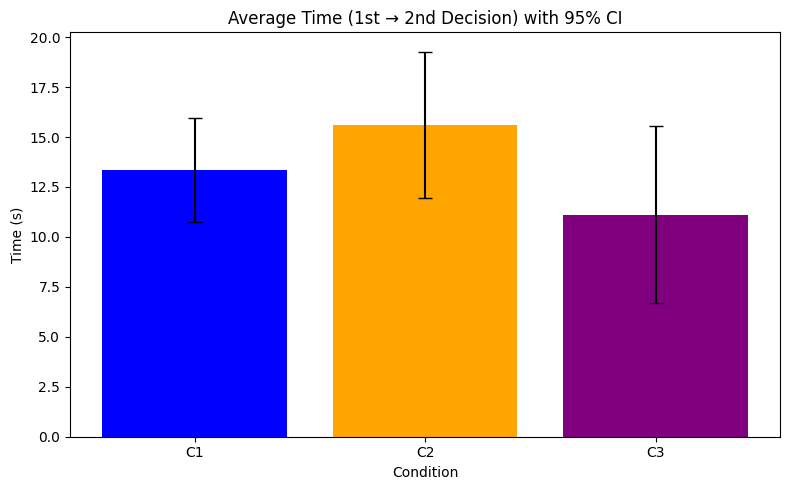

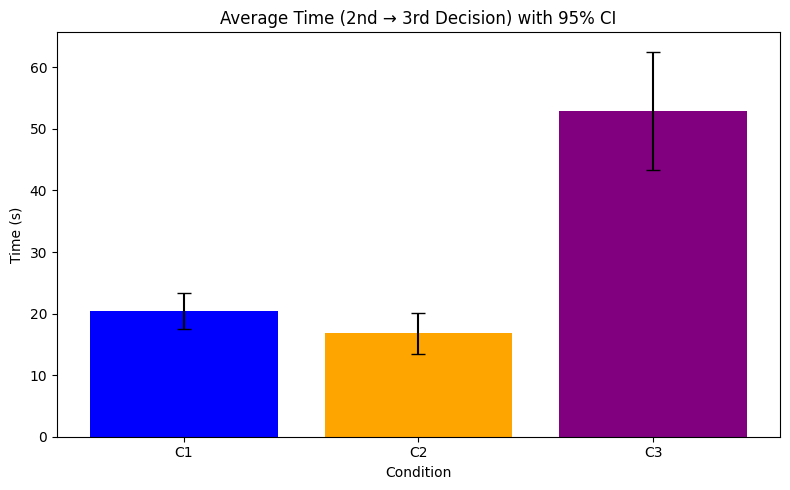

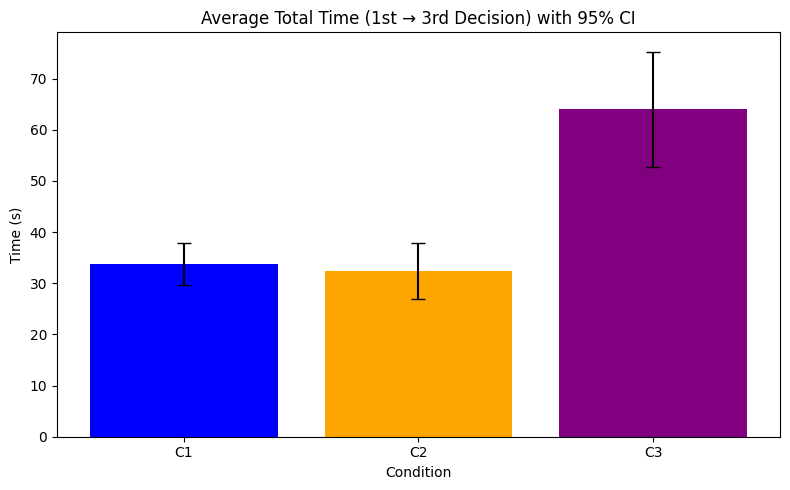

In [ ]:
# === Compute final averages and confidence intervals ===

summary = {}

print("\n=== Overall summary across ALL files ===")
for cond in sorted(all_times_by_condition.keys()):
    times_total = all_times_by_condition[cond]
    times_1_2 = all_time1_2_by_condition[cond]
    times_2_3 = all_time2_3_by_condition[cond]

    def compute_stats(data):
        n = len(data)
        mean = np.mean(data) if n > 0 else 0
        std = np.std(data, ddof=1) if n > 1 else 0
        if n > 1:
            ci_margin = stats.t.ppf(0.975, df=n-1) * (std / np.sqrt(n))
        else:
            ci_margin = 0
        return mean, ci_margin, n

    mean_total, ci_total, n_total = compute_stats(times_total)
    mean_1_2, ci_1_2, n_1_2 = compute_stats(times_1_2)
    mean_2_3, ci_2_3, n_2_3 = compute_stats(times_2_3)

    change_counts = all_change_counts_by_condition[cond]
    total_questions = sum(change_counts.values())

    print(f"\nCondition {cond}:")
    print(f"  Total questions: {total_questions}")
    print(f"  Time 1→2 mean: {mean_1_2:.2f} ± {ci_1_2:.2f} sec")
    print(f"  Time 2→3 mean: {mean_2_3:.2f} ± {ci_2_3:.2f} sec")
    print(f"  Total time mean: {mean_total:.2f} ± {ci_total:.2f} sec")

    for change_type, count in change_counts.items():
        percentage = (count / total_questions) * 100 if total_questions else 0
        print(f"    {change_type}: {count} times ({percentage:.1f}%)")

    summary[cond] = {
        "time1_2_mean": mean_1_2,
        "time1_2_ci": ci_1_2,
        "time2_3_mean": mean_2_3,
        "time2_3_ci": ci_2_3,
        "total_time_mean": mean_total,
        "total_time_ci": ci_total,
        "n": n_total,
    }

# === Plot bar charts ===

def plot_bar_chart(metric, title, ylabel):
    conditions = sorted(summary.keys())
    means = [summary[cond][f"{metric}_mean"] for cond in conditions]
    errors = [summary[cond][f"{metric}_ci"] for cond in conditions]

    plt.figure(figsize=(8, 5))
    plt.bar(conditions, means, yerr=errors, capsize=5, color=["#ea801c", "#1a80bb", "#b8b8b8"])
    plt.xlabel("Condition")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_bar_chart("time1_2", "Average Time (1st → 2nd Decision) with 95% CI", "Time (s)")
plot_bar_chart("time2_3", "Average Time (2nd → 3rd Decision) with 95% CI", "Time (s)")
plot_bar_chart("total_time", "Average Total Time (1st → 3rd Decision) with 95% CI", "Time (s)")